In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import date
import datetime
from pathlib import Path
import seaborn as sns

In [2]:
caminho = r'Z:\Banco SIVEP Exportação'
lista_arquivos = os.listdir(caminho)
lista_datas = []

for arquivo in lista_arquivos:
    #Descobrir a data desse arquivo
    data = os.path.getmtime(f'{caminho}/{arquivo}')
    lista_datas.append((data,arquivo))

lista_datas.sort(reverse=True) #Vai ordenar a lista em ordem decrescente com reverse=True Obs: Ele ordena sempre com o primeiro valor, por isso colocamos data antes de arquivo
ultimo_arquivo = lista_datas[0][1] #Pega o ultimo arquivo
ultimo_arquivo

'Banco SIVEP 20_10_2022 02_32_55.xlsx'

In [3]:
dados = pd.read_excel(f'{caminho}/{ultimo_arquivo}')
#dados = pd.read_excel('Z:/Banco SIVEP Exportação/Banco SIVEP 30_05_2022 09_48_25.xlsx')

In [4]:
dados['Faixa Etaria'] = dados['Faixa Etaria'].map({'0-9 anos':'0-9 anos','10-19 anos':'10-19 anos','20-29 anos':'20-59 anos','30-39 anos':'20-59 anos',
                                                         '40-49 anos':'20-59 anos','50-59 anos':'20-59 anos','60-69 anos':'60 anos ou mais','70-79 anos':'60 anos ou mais',
                                                         '80 e mais anos':'60 anos ou mais'})

In [5]:
dados['pos_pcrflu'] = dados['pos_pcrflu'].map({1:'Sim',2:'Nao',9:'Ignorado'})

In [6]:
dados['tp_flu_pcr'] = dados['tp_flu_pcr'].map({1:'Influenza A',2:'Influenza B'})

In [7]:
dados['pcr_fluasu'] = dados['pcr_fluasu'].map({1:'Influenza A(H1N1)pdm09',2:'Influenza A(H3N2)',3:'Influenza A nao subtipado',
4:'Influenza A nao subtipavel',5:'Inconclusivo',6:'Outro'})

### Começo do filtro da tabela

In [8]:
filtro = dados[['Faixa Etaria','Tem Comorbidade','Houve internacao','Evolucao','pos_pcrflu','tp_flu_pcr','pcr_fluasu','pcr_vsr']]
filtro

,Faixa Etaria,Tem Comorbidade,Houve internacao,Evolucao,pos_pcrflu,tp_flu_pcr,pcr_fluasu,pcr_vsr
0,0-9 anos,Não,Sim,Cura,NaN,NaN,NaN,NaN
1,0-9 anos,Sim,Sim,Cura,NaN,NaN,NaN,NaN
2,10-19 anos,Sim,Sim,Cura,NaN,NaN,NaN,NaN
3,60 anos ou mais,Sim,Sim,Óbito,NaN,NaN,NaN,NaN
4,0-9 anos,Sim,Sim,Cura,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
183666,20-59 anos,Sim,Sim,Óbito,NaN,NaN,NaN,NaN
183667,60 anos ou mais,Sim,Sim,Óbito,NaN,NaN,NaN,NaN
183668,20-59 anos,Sim,Sim,Ignorado,NaN,NaN,NaN,NaN
183669,60 anos ou mais,Sim,Sim,Cura,NaN,NaN,NaN,NaN


### Inicio possui comorbidade influenza - Hospitalizações

In [9]:
temComorbInfluHosp = filtro[['Faixa Etaria','Houve internacao','Tem Comorbidade','pos_pcrflu']]
temComorbInfluHosp = temComorbInfluHosp.loc[temComorbInfluHosp['pos_pcrflu']=='Sim']
temComorbInfluHosp = temComorbInfluHosp.loc[temComorbInfluHosp['Houve internacao']=='Sim']
temComorbInfluHosp = temComorbInfluHosp.loc[temComorbInfluHosp['Tem Comorbidade']=='Sim']
temComorbInfluHosp = temComorbInfluHosp.groupby('Faixa Etaria').count()
temComorbInfluHosp

,Houve internacao,Tem Comorbidade,pos_pcrflu
Faixa Etaria,,,
0-9 anos,37,37,37
10-19 anos,19,19,19
20-59 anos,141,141,141
60 anos ou mais,344,344,344


In [10]:
totalTemComorbInfluHosp = temComorbInfluHosp['pos_pcrflu'].sum()

In [11]:
temComorbInfluHosp.insert(3,'Total Hospitalizacoes Influenza',np.nan)
temComorbInfluHosp['Total Hospitalizacoes Influenza'] = temComorbInfluHosp['Total Hospitalizacoes Influenza'].fillna(totalTemComorbInfluHosp)
temComorbInfluHosp

,Houve internacao,Tem Comorbidade,pos_pcrflu,Total Hospitalizacoes Influenza
Faixa Etaria,,,,
0-9 anos,37,37,37,541.0
10-19 anos,19,19,19,541.0
20-59 anos,141,141,141,541.0
60 anos ou mais,344,344,344,541.0


In [12]:
temComorbInfluHosp['Calculo'] = (temComorbInfluHosp['pos_pcrflu']/temComorbInfluHosp['Total Hospitalizacoes Influenza']) * 100
temComorbInfluHosp

,Houve internacao,Tem Comorbidade,pos_pcrflu,Total Hospitalizacoes Influenza,Calculo
Faixa Etaria,,,,,
0-9 anos,37,37,37,541.0,6.839187
10-19 anos,19,19,19,541.0,3.512015
20-59 anos,141,141,141,541.0,26.062847
60 anos ou mais,344,344,344,541.0,63.585952


In [13]:
temComorbInfluHosp = temComorbInfluHosp['Calculo']

### Inicio Não Tem Comorbidade Influenza - Hospitalizações

In [14]:
naoTemComorbInfluHosp = filtro[['Faixa Etaria','Houve internacao','Tem Comorbidade','pos_pcrflu']]
naoTemComorbInfluHosp = naoTemComorbInfluHosp.loc[naoTemComorbInfluHosp['pos_pcrflu']=='Sim']
naoTemComorbInfluHosp = naoTemComorbInfluHosp.loc[naoTemComorbInfluHosp['Houve internacao']=='Sim']
naoTemComorbInfluHosp = naoTemComorbInfluHosp.loc[naoTemComorbInfluHosp['Tem Comorbidade']=='Não']
naoTemComorbInfluHosp = naoTemComorbInfluHosp.groupby('Faixa Etaria').count()
naoTemComorbInfluHosp

,Houve internacao,Tem Comorbidade,pos_pcrflu
Faixa Etaria,,,
0-9 anos,55,55,55
10-19 anos,12,12,12
20-59 anos,47,47,47
60 anos ou mais,38,38,38


In [15]:
totalNaoTemComorbInfluHosp = naoTemComorbInfluHosp['pos_pcrflu'].sum()

In [16]:
naoTemComorbInfluHosp.insert(3,'Total Hospitalizacoes Influenza',np.nan)
naoTemComorbInfluHosp['Total Hospitalizacoes Influenza'] = naoTemComorbInfluHosp['Total Hospitalizacoes Influenza'].fillna(totalNaoTemComorbInfluHosp)
naoTemComorbInfluHosp

,Houve internacao,Tem Comorbidade,pos_pcrflu,Total Hospitalizacoes Influenza
Faixa Etaria,,,,
0-9 anos,55,55,55,152.0
10-19 anos,12,12,12,152.0
20-59 anos,47,47,47,152.0
60 anos ou mais,38,38,38,152.0


In [17]:
naoTemComorbInfluHosp['Calculo'] = (naoTemComorbInfluHosp['pos_pcrflu']/naoTemComorbInfluHosp['Total Hospitalizacoes Influenza']) * 100
naoTemComorbInfluHosp

,Houve internacao,Tem Comorbidade,pos_pcrflu,Total Hospitalizacoes Influenza,Calculo
Faixa Etaria,,,,,
0-9 anos,55,55,55,152.0,36.184211
10-19 anos,12,12,12,152.0,7.894737
20-59 anos,47,47,47,152.0,30.921053
60 anos ou mais,38,38,38,152.0,25.000000


In [18]:
naoTemComorbInfluHosp = naoTemComorbInfluHosp['Calculo']

In [19]:
faixaEtaria = naoTemComorbInfluHosp.to_frame()
faixaEtaria = faixaEtaria.reset_index()
faixaEtaria = faixaEtaria['Faixa Etaria']

In [20]:
legenda = pd.DataFrame(columns=['Tem comorbidade','Não tem comorbidade'])

### Inicio tem comorbidade VSR - Hospitalizações

In [21]:
temComorbVSRHosp = filtro[['Faixa Etaria','Houve internacao','Tem Comorbidade','pcr_vsr']]
temComorbVSRHosp = temComorbVSRHosp.loc[temComorbVSRHosp['pcr_vsr']==1]
temComorbVSRHosp = temComorbVSRHosp.loc[temComorbVSRHosp['Houve internacao']=='Sim']
temComorbVSRHosp = temComorbVSRHosp.loc[temComorbVSRHosp['Tem Comorbidade']=='Sim']
temComorbVSRHosp = temComorbVSRHosp.groupby('Faixa Etaria').count()
temComorbVSRHosp

,Houve internacao,Tem Comorbidade,pcr_vsr
Faixa Etaria,,,
0-9 anos,329,329,329
10-19 anos,11,11,11
20-59 anos,91,91,91
60 anos ou mais,220,220,220


In [22]:
totalTemComorbVSRHosp = temComorbVSRHosp['pcr_vsr'].sum()

In [23]:
temComorbVSRHosp.insert(3,'Total Hospitalizacoes VSR',np.nan)
temComorbVSRHosp['Total Hospitalizacoes VSR'] = temComorbVSRHosp['Total Hospitalizacoes VSR'].fillna(totalTemComorbVSRHosp)
temComorbVSRHosp

,Houve internacao,Tem Comorbidade,pcr_vsr,Total Hospitalizacoes VSR
Faixa Etaria,,,,
0-9 anos,329,329,329,651.0
10-19 anos,11,11,11,651.0
20-59 anos,91,91,91,651.0
60 anos ou mais,220,220,220,651.0


In [24]:
temComorbVSRHosp['Calculo'] = (temComorbVSRHosp['pcr_vsr']/temComorbVSRHosp['Total Hospitalizacoes VSR']) * 100
temComorbVSRHosp

,Houve internacao,Tem Comorbidade,pcr_vsr,Total Hospitalizacoes VSR,Calculo
Faixa Etaria,,,,,
0-9 anos,329,329,329,651.0,50.537634
10-19 anos,11,11,11,651.0,1.689708
20-59 anos,91,91,91,651.0,13.978495
60 anos ou mais,220,220,220,651.0,33.794163


In [25]:
temComorbVSRHosp = temComorbVSRHosp['Calculo']

### Inicio nao tem comorbidade VSR - Hospitalizações

In [26]:
naoTemComorbVSRHosp = filtro[['Faixa Etaria','Houve internacao','Tem Comorbidade','pcr_vsr']]
naoTemComorbVSRHosp = naoTemComorbVSRHosp.loc[naoTemComorbVSRHosp['pcr_vsr']==1]
naoTemComorbVSRHosp = naoTemComorbVSRHosp.loc[naoTemComorbVSRHosp['Houve internacao']=='Sim']
naoTemComorbVSRHosp = naoTemComorbVSRHosp.loc[naoTemComorbVSRHosp['Tem Comorbidade']=='Não']
naoTemComorbVSRHosp = naoTemComorbVSRHosp.groupby('Faixa Etaria').count()
naoTemComorbVSRHosp

,Houve internacao,Tem Comorbidade,pcr_vsr
Faixa Etaria,,,
0-9 anos,1426,1426,1426
10-19 anos,2,2,2
20-59 anos,22,22,22
60 anos ou mais,14,14,14


In [27]:
totalNaoTemComorbVSRHosp = naoTemComorbVSRHosp['pcr_vsr'].sum()

In [28]:
naoTemComorbVSRHosp.insert(3,'Total Hospitalizacoes VSR',np.nan)
naoTemComorbVSRHosp['Total Hospitalizacoes VSR'] = naoTemComorbVSRHosp['Total Hospitalizacoes VSR'].fillna(totalNaoTemComorbVSRHosp)
naoTemComorbVSRHosp

,Houve internacao,Tem Comorbidade,pcr_vsr,Total Hospitalizacoes VSR
Faixa Etaria,,,,
0-9 anos,1426,1426,1426,1464.0
10-19 anos,2,2,2,1464.0
20-59 anos,22,22,22,1464.0
60 anos ou mais,14,14,14,1464.0


In [29]:
naoTemComorbVSRHosp['Calculo'] = (naoTemComorbVSRHosp['pcr_vsr']/naoTemComorbVSRHosp['Total Hospitalizacoes VSR']) * 100
naoTemComorbVSRHosp

,Houve internacao,Tem Comorbidade,pcr_vsr,Total Hospitalizacoes VSR,Calculo
Faixa Etaria,,,,,
0-9 anos,1426,1426,1426,1464.0,97.404372
10-19 anos,2,2,2,1464.0,0.136612
20-59 anos,22,22,22,1464.0,1.502732
60 anos ou mais,14,14,14,1464.0,0.956284


In [30]:
naoTemComorbVSRHosp = naoTemComorbVSRHosp['Calculo']

In [31]:
width=0.2

In [76]:
legenda = pd.DataFrame(columns=['Tem comorbidade: Influenza','Não tem comorbidade: Influenza','Tem comorbidade: VSR','Não tem comorbidade: VSR'])
legenda2 = pd.DataFrame(columns=['Tem comorbidade: VSR','Tem comorbidade: Influenza','Não tem comorbidade: VSR','Não tem comorbidade: Influenza'])

[Text(0, 0, '0%'),
 Text(0, 10, '10%'),
 Text(0, 20, '20%'),
 Text(0, 30, '30%'),
 Text(0, 40, '40%'),
 Text(0, 50, '50%'),
 Text(0, 60, '60%'),
 Text(0, 70, '70%'),
 Text(0, 80, '80%'),
 Text(0, 90, '90%'),
 Text(0, 100, '100%')]

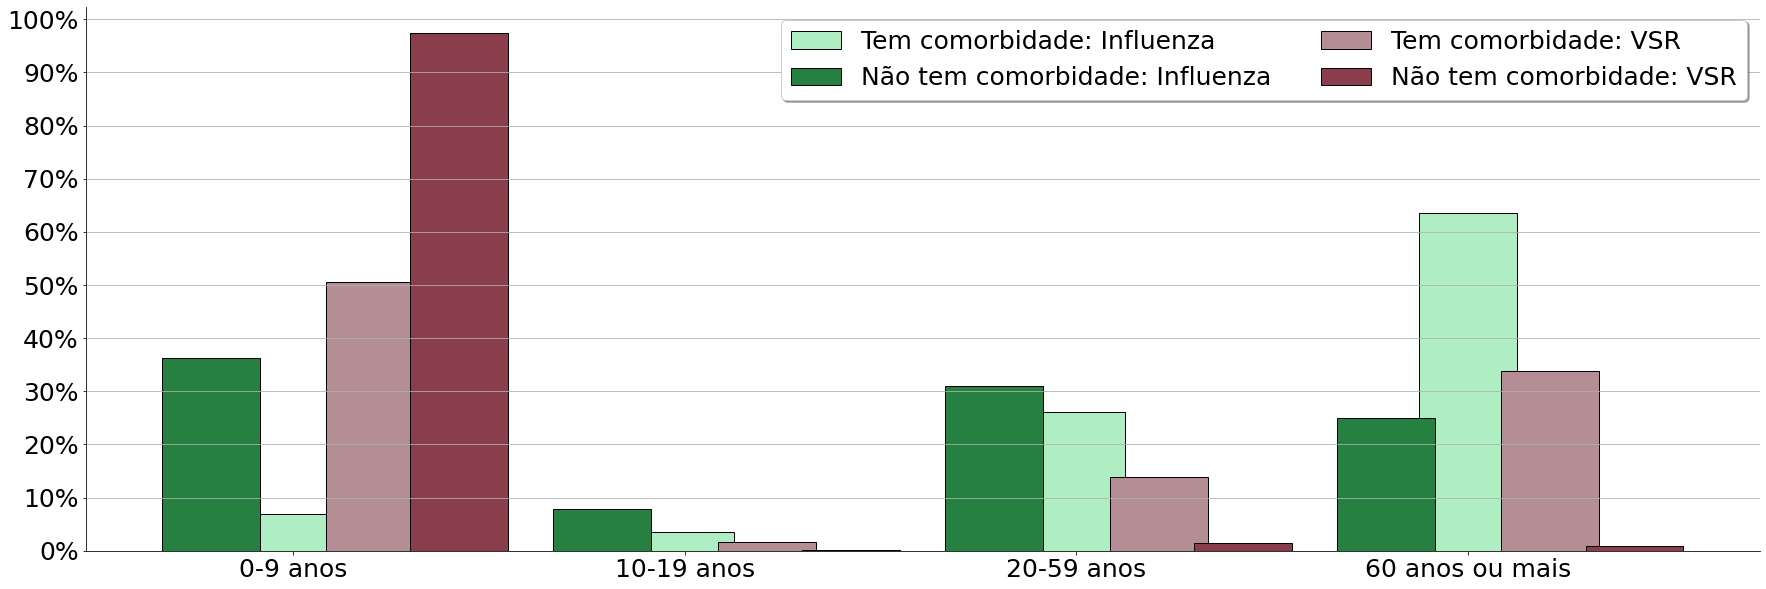

In [77]:
plt.figure(figsize=(30,10))
plt.bar(faixaEtaria,temComorbInfluHosp,width,color='#afedc2',edgecolor='#000000')
plt.bar(np.arange(0,np.size(faixaEtaria))-0.21,naoTemComorbInfluHosp,width,color='#268042',edgecolor='#000000')
plt.bar(np.arange(0,np.size(faixaEtaria))+0.21,temComorbVSRHosp,width,color='#b58d94',edgecolor='#000000')
plt.bar(np.arange(0,np.size(faixaEtaria))+0.425,naoTemComorbVSRHosp,width,color='#8a3e4b',edgecolor='#000000')
plt.legend(legenda,ncol=2,fontsize=25,shadow=True)
plt.xticks(fontsize=25)
plt.yticks(np.arange(0,110,10),fontsize=25)
sns.despine()
plt.grid(axis='y')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()])

In [100]:
legenda = pd.DataFrame(columns=['Tem comorbidade: Influenza','Não tem comorbidade: Influenza','Tem comorbidade: VSR','Não tem comorbidade: VSR'])
legenda2 = pd.DataFrame(columns=['Tem comorbidade: VSR','Não tem comorbidade: VSR','Tem comorbidade: Influenza','Não tem comorbidade: Influenza'])

[Text(0, 0, '0%'),
 Text(0, 10, '10%'),
 Text(0, 20, '20%'),
 Text(0, 30, '30%'),
 Text(0, 40, '40%'),
 Text(0, 50, '50%'),
 Text(0, 60, '60%'),
 Text(0, 70, '70%'),
 Text(0, 80, '80%'),
 Text(0, 90, '90%'),
 Text(0, 100, '100%'),
 Text(0, 110, '110%'),
 Text(0, 120, '120%'),
 Text(0, 130, '130%'),
 Text(0, 140, '140%')]

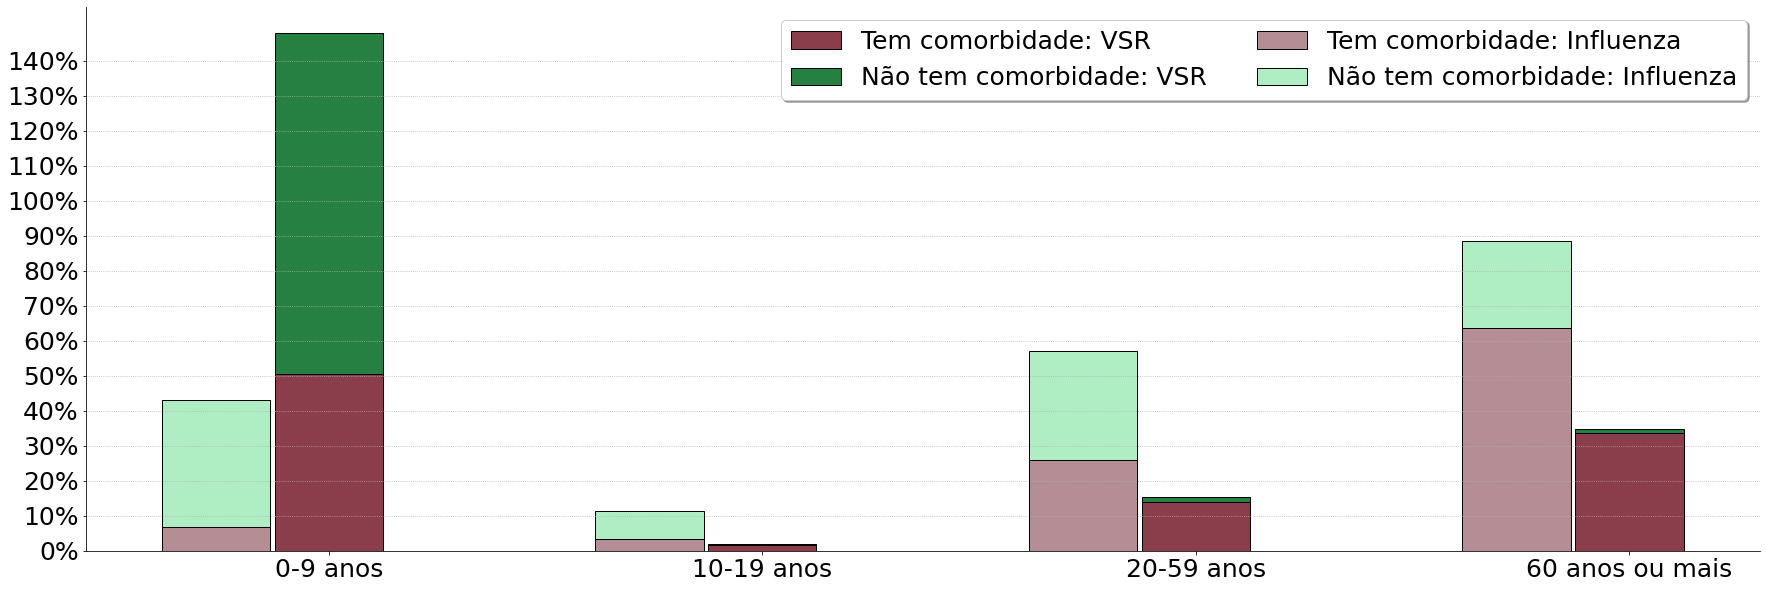

In [101]:
plt.figure(figsize=(30,10))
plt.bar(faixaEtaria,temComorbVSRHosp,width,color='#8a3e4b',edgecolor='#000000')
plt.bar(faixaEtaria,naoTemComorbVSRHosp,width,bottom=temComorbVSRHosp,color='#268042',edgecolor='#000000')
plt.bar(np.arange(0,np.size(faixaEtaria))-0.26,temComorbInfluHosp,width,color='#b58d94',edgecolor='#000000')
plt.bar(np.arange(0,np.size(faixaEtaria))-0.26,naoTemComorbInfluHosp,width,bottom=temComorbInfluHosp,color='#afedc2',edgecolor='#000000')
plt.legend(legenda2,ncol=2,fontsize=25,shadow=True)
plt.xticks(fontsize=25)
plt.yticks(np.arange(0,150,10),fontsize=25)
sns.despine()
plt.grid(axis='y',linestyle='dotted')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()])

### Inicio tem comorbidade influenza: Obitos

In [34]:
temComorbInfluObito = filtro[['Faixa Etaria','Evolucao','Tem Comorbidade','pos_pcrflu']]
temComorbInfluObito = temComorbInfluObito.loc[temComorbInfluObito['pos_pcrflu']=='Sim']
temComorbInfluObito = temComorbInfluObito.loc[temComorbInfluObito['Evolucao']=='Óbito']
temComorbInfluObito = temComorbInfluObito.loc[temComorbInfluObito['Tem Comorbidade']=='Sim']
temComorbInfluObito = temComorbInfluObito.groupby('Faixa Etaria').count()
temComorbInfluObito

,Evolucao,Tem Comorbidade,pos_pcrflu
Faixa Etaria,,,
0-9 anos,2,2,2
10-19 anos,1,1,1
20-59 anos,18,18,18
60 anos ou mais,83,83,83


In [35]:
totalTemComorbInfluObito = temComorbInfluObito['pos_pcrflu'].sum()

In [36]:
temComorbInfluObito.insert(3,'Total Obitos Influenza',np.nan)
temComorbInfluObito['Total Obitos Influenza'] = temComorbInfluObito['Total Obitos Influenza'].fillna(totalTemComorbInfluObito)
temComorbInfluObito

,Evolucao,Tem Comorbidade,pos_pcrflu,Total Obitos Influenza
Faixa Etaria,,,,
0-9 anos,2,2,2,104.0
10-19 anos,1,1,1,104.0
20-59 anos,18,18,18,104.0
60 anos ou mais,83,83,83,104.0


In [37]:
temComorbInfluObito['Calculo'] = (temComorbInfluObito['pos_pcrflu']/temComorbInfluObito['Total Obitos Influenza']) * 100
temComorbInfluObito

,Evolucao,Tem Comorbidade,pos_pcrflu,Total Obitos Influenza,Calculo
Faixa Etaria,,,,,
0-9 anos,2,2,2,104.0,1.923077
10-19 anos,1,1,1,104.0,0.961538
20-59 anos,18,18,18,104.0,17.307692
60 anos ou mais,83,83,83,104.0,79.807692


In [38]:
temComorbInfluObito = temComorbInfluObito['Calculo']

### Inicio nao tem comorbidade influenza: Obito

In [39]:
base = filtro.groupby('Faixa Etaria').count()
base = base.drop(columns=['Tem Comorbidade','Houve internacao','pos_pcrflu','Evolucao','tp_flu_pcr','pcr_fluasu','pcr_vsr'])

In [40]:
naoTemComorbInfluObito = filtro[['Faixa Etaria','Evolucao','Tem Comorbidade','pos_pcrflu']]
naoTemComorbInfluObito = naoTemComorbInfluObito.loc[naoTemComorbInfluObito['pos_pcrflu']=='Sim']
naoTemComorbInfluObito = naoTemComorbInfluObito.loc[naoTemComorbInfluObito['Evolucao']=='Óbito']
naoTemComorbInfluObito = naoTemComorbInfluObito.loc[naoTemComorbInfluObito['Tem Comorbidade']=='Não']
naoTemComorbInfluObito = naoTemComorbInfluObito.groupby('Faixa Etaria').count()
naoTemComorbInfluObito = naoTemComorbInfluObito.merge(base,how='outer',left_index=True,right_index=True)
naoTemComorbInfluObito = naoTemComorbInfluObito.fillna(0)
naoTemComorbInfluObito

,Evolucao,Tem Comorbidade,pos_pcrflu
Faixa Etaria,,,
0-9 anos,0.0,0.0,0.0
10-19 anos,0.0,0.0,0.0
20-59 anos,5.0,5.0,5.0
60 anos ou mais,8.0,8.0,8.0


In [41]:
totalNaoTemComorbInfluObito = naoTemComorbInfluObito['pos_pcrflu'].sum()

In [42]:
naoTemComorbInfluObito.insert(3,'Total Obitos Influenza',np.nan)
naoTemComorbInfluObito['Total Obitos Influenza'] = naoTemComorbInfluObito['Total Obitos Influenza'].fillna(totalNaoTemComorbInfluObito)
naoTemComorbInfluObito

,Evolucao,Tem Comorbidade,pos_pcrflu,Total Obitos Influenza
Faixa Etaria,,,,
0-9 anos,0.0,0.0,0.0,13.0
10-19 anos,0.0,0.0,0.0,13.0
20-59 anos,5.0,5.0,5.0,13.0
60 anos ou mais,8.0,8.0,8.0,13.0


In [43]:
naoTemComorbInfluObito['Calculo'] = (naoTemComorbInfluObito['pos_pcrflu']/naoTemComorbInfluObito['Total Obitos Influenza']) * 100
naoTemComorbInfluObito

,Evolucao,Tem Comorbidade,pos_pcrflu,Total Obitos Influenza,Calculo
Faixa Etaria,,,,,
0-9 anos,0.0,0.0,0.0,13.0,0.000000
10-19 anos,0.0,0.0,0.0,13.0,0.000000
20-59 anos,5.0,5.0,5.0,13.0,38.461538
60 anos ou mais,8.0,8.0,8.0,13.0,61.538462


In [44]:
naoTemComorbInfluObito = naoTemComorbInfluObito['Calculo']

### Inicio tem comorbidade VSR: Obito

In [45]:
temComorbVSRObito = filtro[['Faixa Etaria','Evolucao','Tem Comorbidade','pcr_vsr']]
temComorbVSRObito = temComorbVSRObito.loc[temComorbVSRObito['pcr_vsr']==1]
temComorbVSRObito = temComorbVSRObito.loc[temComorbVSRObito['Evolucao']=='Óbito']
temComorbVSRObito = temComorbVSRObito.loc[temComorbVSRObito['Tem Comorbidade']=='Sim']
temComorbVSRObito = temComorbVSRObito.groupby('Faixa Etaria').count()
temComorbVSRObito

,Evolucao,Tem Comorbidade,pcr_vsr
Faixa Etaria,,,
0-9 anos,3,3,3
10-19 anos,1,1,1
20-59 anos,16,16,16
60 anos ou mais,58,58,58


In [46]:
totalTemComorbVSRObito = temComorbVSRObito['pcr_vsr'].sum()

In [47]:
temComorbVSRObito.insert(3,'Total Obitos VSR',np.nan)
temComorbVSRObito['Total Obitos VSR'] = temComorbVSRObito['Total Obitos VSR'].fillna(totalTemComorbVSRObito)
temComorbVSRObito

,Evolucao,Tem Comorbidade,pcr_vsr,Total Obitos VSR
Faixa Etaria,,,,
0-9 anos,3,3,3,78.0
10-19 anos,1,1,1,78.0
20-59 anos,16,16,16,78.0
60 anos ou mais,58,58,58,78.0


In [48]:
temComorbVSRObito['Calculo'] = (temComorbVSRObito['pcr_vsr']/temComorbVSRObito['Total Obitos VSR']) * 100
temComorbVSRObito

,Evolucao,Tem Comorbidade,pcr_vsr,Total Obitos VSR,Calculo
Faixa Etaria,,,,,
0-9 anos,3,3,3,78.0,3.846154
10-19 anos,1,1,1,78.0,1.282051
20-59 anos,16,16,16,78.0,20.512821
60 anos ou mais,58,58,58,78.0,74.358974


In [49]:
temComorbVSRObito = temComorbVSRObito['Calculo']

### Inicio nao tem comorbidade VSR: Obito

In [50]:
naoTemComorbVSRObito = filtro[['Faixa Etaria','Evolucao','Tem Comorbidade','pcr_vsr']]
naoTemComorbVSRObito = naoTemComorbVSRObito.loc[naoTemComorbVSRObito['pcr_vsr']==1]
naoTemComorbVSRObito = naoTemComorbVSRObito.loc[naoTemComorbVSRObito['Evolucao']=='Óbito']
naoTemComorbVSRObito = naoTemComorbVSRObito.loc[naoTemComorbVSRObito['Tem Comorbidade']=='Não']
naoTemComorbVSRObito = naoTemComorbVSRObito.groupby('Faixa Etaria').count()
naoTemComorbVSRObito = naoTemComorbVSRObito.merge(base,how='outer',left_index=True,right_index=True)
naoTemComorbVSRObito = naoTemComorbVSRObito.fillna(0)
naoTemComorbVSRObito

,Evolucao,Tem Comorbidade,pcr_vsr
Faixa Etaria,,,
0-9 anos,10.0,10.0,10.0
10-19 anos,0.0,0.0,0.0
20-59 anos,1.0,1.0,1.0
60 anos ou mais,3.0,3.0,3.0


In [51]:
totalNaoTemComorbVSRObito = naoTemComorbVSRObito['pcr_vsr'].sum()

In [52]:
naoTemComorbVSRObito.insert(3,'Total Obitos VSR',np.nan)
naoTemComorbVSRObito['Total Obitos VSR'] = naoTemComorbVSRObito['Total Obitos VSR'].fillna(totalNaoTemComorbVSRObito)
naoTemComorbVSRObito

,Evolucao,Tem Comorbidade,pcr_vsr,Total Obitos VSR
Faixa Etaria,,,,
0-9 anos,10.0,10.0,10.0,14.0
10-19 anos,0.0,0.0,0.0,14.0
20-59 anos,1.0,1.0,1.0,14.0
60 anos ou mais,3.0,3.0,3.0,14.0


In [53]:
naoTemComorbVSRObito['Calculo'] = (naoTemComorbVSRObito['pcr_vsr']/naoTemComorbVSRObito['Total Obitos VSR']) * 100
naoTemComorbVSRObito

,Evolucao,Tem Comorbidade,pcr_vsr,Total Obitos VSR,Calculo
Faixa Etaria,,,,,
0-9 anos,10.0,10.0,10.0,14.0,71.428571
10-19 anos,0.0,0.0,0.0,14.0,0.000000
20-59 anos,1.0,1.0,1.0,14.0,7.142857
60 anos ou mais,3.0,3.0,3.0,14.0,21.428571


In [54]:
naoTemComorbVSRObito = naoTemComorbVSRObito['Calculo']

C:\Users\ryan-rosa\AppData\Local\Temp\ipykernel_13508\385764586.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()])


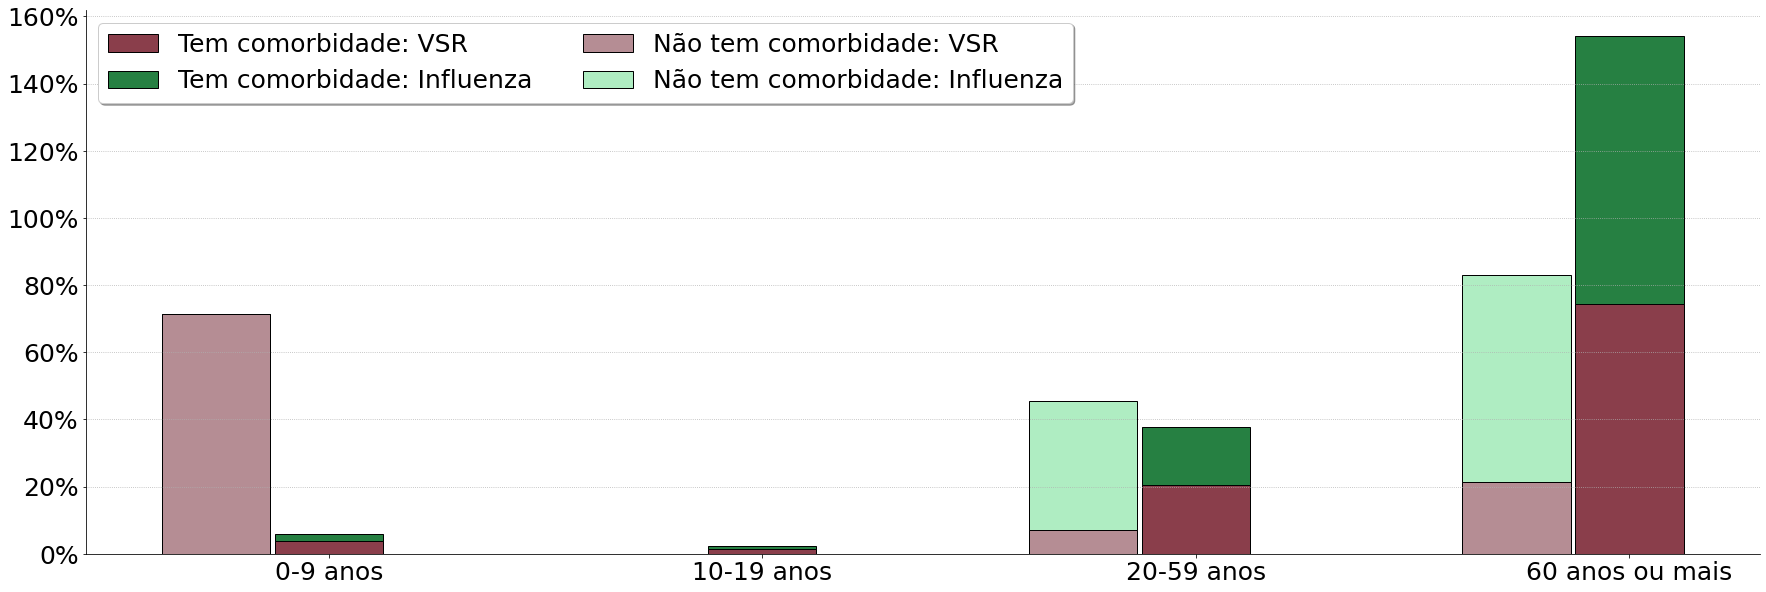

In [97]:
plt.figure(figsize=(30,10))
width = 0.25
plt.bar(faixaEtaria,temComorbVSRObito,width,color='#8a3e4b',edgecolor='#000000')
plt.bar(faixaEtaria,temComorbInfluObito,width,bottom=temComorbVSRObito,color='#268042',edgecolor='#000000')
plt.bar(np.arange(0,np.size(faixaEtaria))-0.26,naoTemComorbVSRObito,width,color='#b58d94',edgecolor='#000000')
plt.bar(np.arange(0,np.size(faixaEtaria))-0.26,naoTemComorbInfluObito,width,bottom=naoTemComorbVSRObito,color='#afedc2',edgecolor='#000000')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(legenda2,fontsize=25,shadow=True,ncol=2)
plt.grid(axis='y',linestyle='dotted')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()])
sns.despine()